# Introduction

This document describes a scenario of data cleaning and exploratory data anlysis.
Suppose you are given a dataset from company that have information about movies,revenues and actor information and you want to do various analysis in it to find patterns in data. 
For our problem, let us describe the situation as below

#Problem
The data is exported as csv files without any metadata. The dataset contains three relations - <b>Actors</b> and <b>Movies</b>
The actor has the following attributes
<table>
  <tr>
    <td>Actor name</td>
    <td>movies he acted in </td> 
    <td>Age</td>
  </tr>
</table>

The movie has the following attributes
<table>
<tr>
    <td>movie name</td>
    <td>genre</td> 
    <td>release year</td>
  </tr>
</table>  

We have a lot of PDF data with additional information about the genre information 

#Goal
1. We want to store this data in a way that is efficient for querying and it should allow us to do large scale analysis. 
2. We want to support cross relational queries like 
<i><b>Give me the list of movies a particular actor has acted between year 1990-200</b></i>

#workflow
To approach this problem, I define a simple workflow diagram as shown below.
The important steps are:
1. The first step in any analysis is data profiling. We play with the data and understand the characterstics of the data. Some of the analysis we do are 
<ul>
<li> Check for duplicate value </li>
<li> Check for missing value</li>
<li> what query can i support after data cleaning</li>
<li> Many more </li>
</ul>
2. During the data profiling we have decided that relational schema is the best way to store the data due to many advantages (refer thesis).So we define a relational schema at this step.
3. The next step is ETL process where we load the data into database
4. We develop statistical test to check the ETL complex transformation.
5. We perform a process called <a hlink="https://en.wikipedia.org/wiki/Record_linkage">Entity resolution</a> to establish relation between movie relation, actor relation and revenue relation.
6. We develop a search engine so that people can play with data.

In [4]:
from IPython.display import Math,Image,display_pretty, display_html,\
display_jpeg, display_png, display_json, display_latex, display_svg,display,HTML,Latex

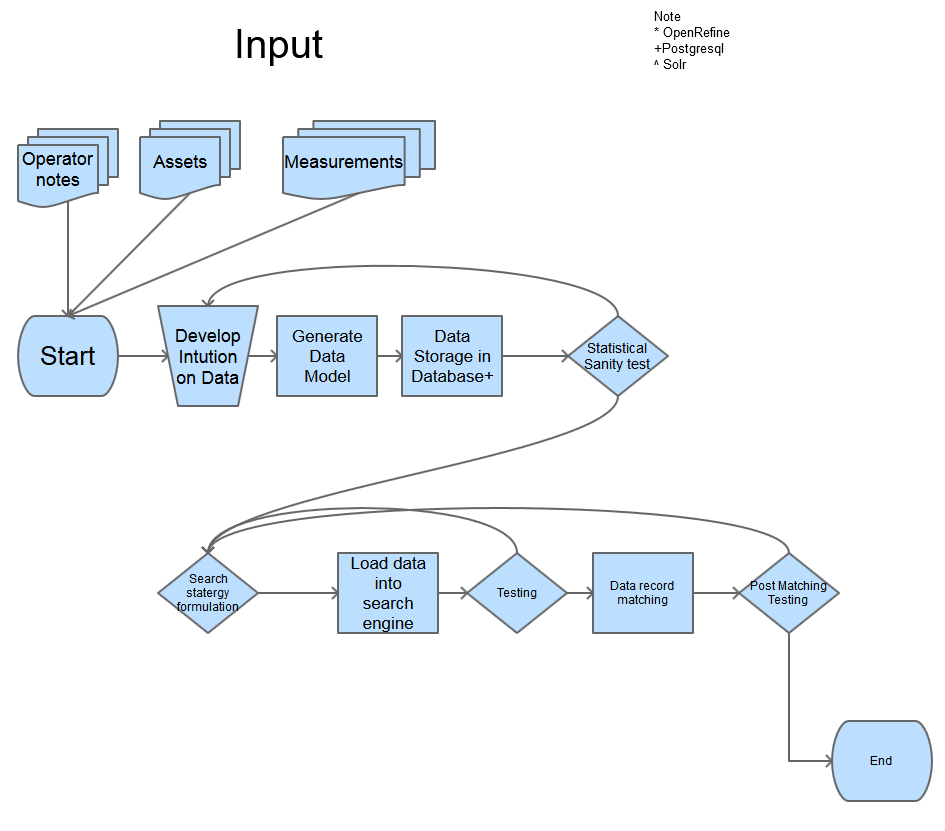

In [5]:
Image(r'C:\Users\dikshith\Google Drive\thesis\theses_templates - Copy\theses_templates\en\images\thesisoverview.png')

#Data profiling
During this process we explore the data to gain insights to our next steps 
1. movie attribute in actor relation and  movie attribute in movie relation are taking about the same movie. So we would like to link them.
2. Before we do that, we want to recognize each movie and actor uniquely so we assign unique id to each movie and actor. This helps us to work with ID's rather than cumbersome text. 
3. It was revealed that the movie names in actor relation and movie relation had a lot of spelling mistake because it was generated by humans which are prone to spell error. It was also noticed that the problem also exist in genre attribute. We have to be resilient this kind errors should be able to say "Toy story 2" and "Toy story II" are the same movies with certain amount of confidence.




#Schema building
The relational database we use will be for analytical process and the typical schema can look like below. 

<table>
  <tr>
    <td><b> Actor Id Int primary key<b></td>
    <td>Actor name text</td>
    <td>movies he acted in text</td> 
    <td>Age Int</td>
    <td>movieId foriegn key refers movie(movieID)</td>
  </tr>
</table>

The movie table will look this
<table>
<tr>
    <td><b>movieID INTprimary key</b></td>
    <td>movie name text </td>
    <td>genre string</td> 
    <td>release year year</td>
</tr>
</table>


In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("ZS0c8El252s")

#ETL
In this part we write scripts to load the data into the schema we defined.Now we have very big database with all the information. But notice that we still cannot query across relation because the movieID in actor relation is empty.

#Entity resolution
Here we solve the problem of missing links with relations. we copy the id of the movie to actor as foriegn key.(Very simiplified scenario as i am not describing a case when actor has acted many movie to keep the discussion simple)

How do we go about this problem ? Remember that we have many issues in the movie name in movie relation and movie name in actor relation does not match with a string search due to spelling mistake or missing word. we should be robust enough to handle this situation.

Let us brefily review the problems that we can encontor

<table>
<tr>
    <td><b>Problems</b></td>
    <td>Example </td>
    <td>Solution</td>
</tr>
<tr>
    <td>String have encoded value</td> 
    <td>For example every movie name in actor relation has year information ex: "Toy story 3 (1995)" but movie relation has only movie name ex : "Toy story 3". </td>
    <td> Preprocess string to remove any informatin not aiding in entity resolution. Als0 remove punctuations and other accents 
</tr>
<tr>
    <td>Order of words may be switched</td> 
    <td>Ex: "The ring" and "ring, the"</td>
    <td> You should handle this case
</tr>
<tr>
    <td>Spell mistakes</td> 
    <td>"armageddon" and "armageon" should be matched</td>
    <td> One technique is <a heref=https://en.wikipedia.org/wiki/N-gram>n-grams</a> helps us here
</tr>
</table>

There are two class of probelm here 
1. <b>fuzzy search on a multi-word string</b>:
One of the algorithm I describe here is the <b>Q-gram with cosine simialrity</b> which helps to solve the problem. (For technical description see thesis.)

2. <b>fuzzy search on  single word string</b>:
Now we want to match genre with genre from some other relation to establish the relational dependency. We will use <b>jaro_winkler algorithm</b>. Why jaro winkler ? . Because the algorithm have rewards better scoring if the first 'p' character match.

Read papers
1. Elmagarmid, A. K., Ipeirotis, P. G., & Verykios, V. S. (2007). Duplicate record detection: A survey. Knowledge and Data Engineering, IEEE Transactions on, 19(1), 1-16.
2. Cohen, W., Ravikumar, P., & Fienberg, S. (2003, August). A comparison of string metrics for matching names and records. In Kdd workshop on data cleaning and object consolidation (Vol. 3, pp. 73-78).
3. Naumann, F., & Herschel, M. (2010). An introduction to duplicate detection. Synthesis Lectures on Data Management, 2(1), 1-87.

#Search engine
Since we have a nice data now. We will let user to use it . Consider here that we had some other information related about the movies in the PDF files. The search provides us uniform access to data across different formats in a single consistent way

I will take an example of solr search engine to say how to work on this. The three main files you have modify are
1. managed_schema: To specify how the data should be represented in the search database and what to do during the index phase and the query phase.
2. data-config.xml : you define how to get the data from database. The path of the database, the relations.
3. Solr-config.xml : You instruct solr on how to behave. It behaves relative well but if you want to tweek it, this is the place.

In [2]:
YouTubeVideo("ClhrrPzJWmI")

#Exploratory analysis
WE have reached the milestone.
Now you can let novice users to understand the data  without knowing any internal of how the data is stored. He uses search interface which statisfies all his interface needs. 
You can also statisfies the analytics needs of the data with the database. It supports bulk data import and export, and supports many programming language , use sql language for reporting.

#In future
You app is famous now and several new companies want to provide you the data. You want to integrate it into your database. Many novice people will do the whole process again. But being a smart engineer as your are, you had thought about this problem in data profiling and you had developed an architecture in mind to handle this situation. The architecture is shown below

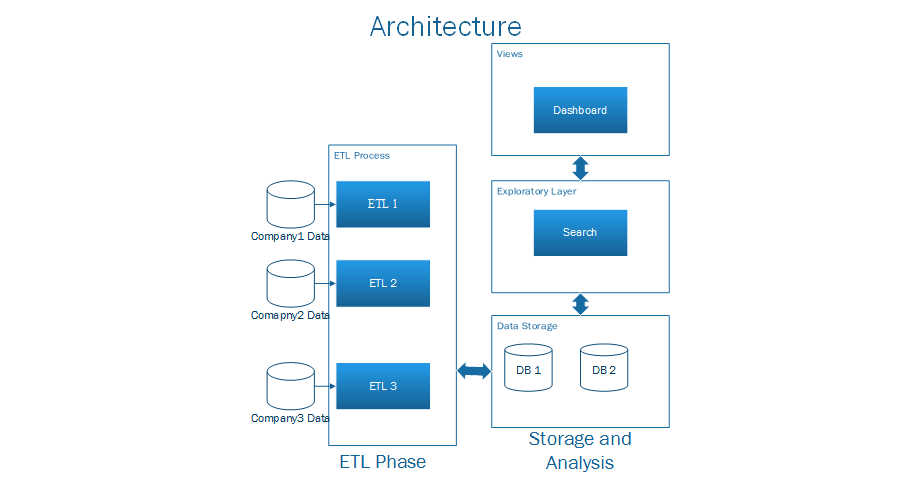

In [3]:
Image(r'C:\Users\dikshith\Google Drive\thesis\theses_templates - Copy\theses_templates\en\images\Data_Model.png')

What you have done is you seggregate the part that are tightly coupled with data from the part that can be reused. Now you have to write new ETL process to store the data in standard format that is already defined. This allows you to reuse the any routines that act on standard data model. 


#Additional details

<h3>Data profiling</h3>
There are many research that predict that you spend most of the time in data mining project here. It is a very important step and it helps in the end, so spend more time on this part compared to other section. There are certain tools that can help you here openrefine, Talend open source tools. 

#Large scale ETL and entity resolution in Apache spark

You compose all tranformations as series of UDF(user defined functions) and chain UDFs to produce end result.
When delevoping UDFs you principles of functional programming and distributed computing to make your code robust.


Example:
<i><b>Input: "Toy stroy 3 1995,adventure". <br/>
Ouput: Sql row of format Row('Toy stroy 3','adventure',1995)
</b></i>
<code>
def extractyear(record):
    return record.split(" ")[-1]
def splitline(record):
    movie,genre = record.split(",")
    return (movie,genre)
def sqltuple(record):
    return Row(record.movie,record.genre,extractyear(record.movie))
    
input =read_input('path to input')

tranformation1 = input.map(splitline)

tranformation2 = transformation1.map(sqltuple)

action1 = tranformation2.collect()

</code> 

For more information read the spark programming guide, lambda functions.

<h3>template for entity resolution</h3>
<code>
#preprocssing
def preprocessing1():
    '''
    You perform some preprocesing as required.
    '''

def preprocessingn():
    '''
    You usualy do many preprocessing to get better matchings.
    '''

#entity resolution
def strategy1():
    '''
    Stategy 1 for entity resolution 
    '''
    
def Jarowinkler(string1,string2):
    '''
    Input 
    string1 : Input string 1
    string2 : Input string 2
    Output
    Score : jaro winkler score between input strings
    '''
    return jarowinkler(string1,string2)
def strategyn(input1,input2):
    '''
    Right now we are in exploration process to find the best algorithm that works us. Each of the algorithm answers a combination of the problems. There is no single best algorithm. The algorithm choice is driven by data characterstics and application needs.
    '''
    
#step 1 : Read input    
input1 = read_input1() // example movies(id,movie name, genre) [(1,'Toy story3',adventure), ...]
input2 = read_input2() // example actor(id,actor name,movie name)[(35,Tom hanks,Toy story 3)]

#Step 2: take cross product of the input
crossprod = cartesian_product(input1,input2)

#step3: apply search statergy
results = crossprod.map(jarowinkler)


#step4: filter the outliers
best_results = results.filter(lambda record: record.score > THRESHOLD) 

#step5: write this relation you have established back into database
best_results.write_to_db()
</code>

#Where to go from here
Note we covered a broad range of topics here. Each of this topic can be book for themselves. 
Some of the hints i want to cover here is:
1. Long list of things that can be done in data profiling. - No extact science. Its often the black art in data science.Try different things out, don't assume anything. Follow murphy's law. You improve by doing.
2. Exploring different algorithm for entity resolution and finding the right threshold. - Read research papers. For good recommendation refer thesis.
3. How to step up search engine.- Read book "Information retrieval" for theory, do getting started guide in solr. See the example schema movie schema for understanding.
4. How to setup database and query ? - Read sql language documentation.


#Feedback
Please provide feedback on the guide. 